In [ ]:
!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/datasetb2d9982.zip

--2023-06-07 11:25:45--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/datasetb2d9982.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.132.238
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.132.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 895569552 (854M) [binary/octet-stream]
Saving to: ‘datasetb2d9982.zip’

datasetb2d9982.zip  100%[===================>] 854.08M  13.8MB/s    in 65s     

2023-06-07 11:26:52 (13.1 MB/s) - ‘datasetb2d9982.zip’ saved [895569552/895569552]



In [ ]:
!unzip datasetb2d9982.zip

Archive:  datasetb2d9982.zip
   creating: dataset/
  inflating: dataset/sample_submission.csv  
  inflating: dataset/train.csv       
  inflating: dataset/test.csv        


In [ ]:
!pip  install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import csv
import os
import random
import torch
import torch
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import sklearn.model_selection as model_selection
from transformers import BertForSequenceClassification, BertTokenizerFast
import time
import copy
from tqdm.notebook import tqdm

In [ ]:
test_data = pd.read_csv("/content/dataset/test.csv")

In [ ]:
test_data.shape

(734736, 5)

In [ ]:
test_new = test_data.iloc[: 15, : ]

In [ ]:
test_new.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID
0,604373,Manuel d'Héliogravure Et de Photogravure En Re...,NaN,NaN,6142
1,1729783,DCGARING Microfiber Throw Blanket Warm Fuzzy P...,[QUALITY GUARANTEED: Luxury cozy plush polyest...,<b>DCGARING Throw Blanket</b><br><br> <b>Size ...,1622
2,1871949,I-Match Auto Parts Front License Plate Bracket...,"[Front License Plate Bracket Made Of Plastic,D...",Replacement for The Following Vehicles:2020 LE...,7540
3,1107571,PinMart Gold Plated Excellence in Service 1 Ye...,[Available as a single item or bulk packed. Se...,Our Excellence in Service Lapel Pins feature a...,12442
4,624253,"Visual Mathematics, Illustrated by the TI-92 a...",NaN,NaN,6318


In [ ]:
test_new.to_csv("test_new.csv")

In [ ]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
df=pd.read_csv('/content/dataset/train.csv')

In [ ]:
df.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000


In [ ]:
num_labels=df["PRODUCT_LENGTH"].nunique()

In [ ]:
id2lbl={lbl: idx for idx,lbl in enumerate(list(df["PRODUCT_LENGTH"].unique()))}
lbl2id={lbl:idx for idx,lbl in id2lbl.items()}

In [ ]:
set_seed()

In [ ]:
df["PRODUCT_LENGTH"]=df["PRODUCT_LENGTH"].map(id2lbl)

In [ ]:
def create_folds(data, num_splits):
    data["kfold"] = -1
    data = data.sample(frac=1).reset_index(drop=True)
    y=df["PRODUCT_LENGTH"]
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=y)):
        data.loc[v_, 'kfold'] = f
    return data

In [ ]:
df=create_folds(df, 5)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:

df.head(20)

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold
0,1439802,Dahee Men's Hot Shooting Game Mens Black Sweat...,[Hot Game Mens Black Sweater Cosplay Hoodie Co...,<b>Item specifics: </b><br> Item type: hoodie<...,12017,145,0
1,2249112,IndianShelf 2 Pieces Decorative Knobs | Cerami...,[6 Month Replacement Guarantee on Manufacturin...,About Cupboard Knobs Handles: Each knob is han...,8282,2078,0
2,1653676,SONA Women's Bee Heart Cotton Straps T-Shirt B...,"[Fit Type: regular,Fabric: Cotton; Cotton Stra...",Get the support and comfort you've been lookin...,3009,2,0
3,1449012,Pinhole Cushioned Sneakers Low Top Slip On Fla...,[Breathable Perforation Ideal For When You Nee...,There is a time and a place for elaborate shoe...,3251,167,0
4,38734,Invisible power: The Elizabethan secret servic...,NaN,NaN,1,72,0
5,2186623,Clovia Women's Padded Non-Wired Full Cup T-Shi...,"[Product Type: Full Coverage Bra,Fabric: Polya...",NaN,3009,79,0
6,511413,God Grant Me The Serenity: The Serenity Prayer...,NaN,NaN,1,81,0
7,2753610,Victoria's Secret Pink Wear Everywhere Lightly...,[Victoria's Secret PINK Wear Everywhere T-Shir...,Victoria's Secret PINK Wear Everywhere T-Shirt...,3009,37,0
8,1107983,Petsplanet Nylon Adjustable Collar & Leash Lar...,"[Nylon Dog Collar & Leash Set,Durable & Long L...",Petsplanet High Quality Nylon Adjustable Colla...,7095,8,0
9,2559169,"Latepis Black Round Rug 3 ft, Faux Fur Sheepsk...",[Material and Dimension: Made of 100% Faux she...,<b>Latepis Rugs</b><br> <P>*You won't regret b...,1636,1442,0


In [ ]:
import seaborn as sns

<Axes: xlabel='kfold', ylabel='count'>

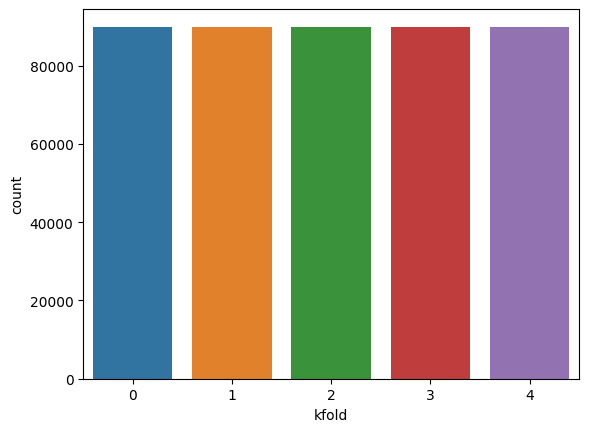

In [ ]:
sns.countplot(x='kfold' , data=df)

In [ ]:
train_data = df

<ipython-input-37-dc2a10896668>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-dc2a10896668>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-dc2a10896668>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-dc2a10896668>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-dc2a10896668>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold
0,101521,Secret Things: Twelve Tales to Terrify,NaN,NaN,104,17,0
1,288840,The Life of Andrew Marvel,NaN,NaN,112,45,0
2,646861,L'attente de l'aube,NaN,NaN,99,817,0
3,34064,Jerusalen Libertada: Traduccin En Prosa Del It...,NaN,NaN,6104,151,0
4,2119006,ZIYAA Women's Cotton Regular Kurta (ZIKUCO3215...,"[Kurta Fabric : Cotton,Straight Kurta,Availabl...",NaN,2916,584,0
5,2384908,Foldable Bed Study Table Portable Multifunctio...,[✔Multi-purpose table/desk : Not only work as ...,<p>Use a laptop on the bed -Perfect study on t...,593,8,0
6,1902862,Luvkushcart Designer Rakhi for Brother With Gi...,"[Designer traditional ""Rakhi"",Specially design...","Rakhi symbolizes the spirit of Menhood, friend...",9577,34,0
7,2855426,Complete Avengers Showdown - Official Avengers...,[Texture & Appearance Artwork is printed on 25...,"The love for the supers never end, do they? We...",1557,80,0
8,526573,Lonely Planet Mongolian Phrasebook (Lonely Pla...,NaN,NaN,12318,845,0
9,859627,Springfield Leotard and Skirt,"[Doll Clothes,For 18 inch dolls,Springfield]","Part of the Springfield Collection for 18"" dol...",1775,18,0


In [ ]:
df.loc[df['PRODUCT_LENGTH']==1045].head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold
14464,1701906,Three Keys Jewelry Womens Charming Jewelers Ce...,[Material: White Ceramic&Blue Sand&Galaxy Opal...,<b><br>Our Ceramic rings are known for their l...,9970,1045,0
17673,1957031,ETUDE Soonjung Hydro Barrier Cream 75ml (New V...,Hydro Barrier Cream gently soothes stressed sk...,NaN,10160,1045,0
31021,2550606,NATURALI Pollution Defence Face Wash | With Ch...,[Protects skin from Pollution: Naturali Pollut...,NaN,10158,1045,0
31745,870239,Planet Waves White Pearl Celluloid Guitar Pick...,"[10 picks per package,Medium gauge (70mm) work...",NaN,6859,1045,0
53996,1699921,Three Keys Jewelry Men Bands 8mm Tungsten Hunt...,[Craft: Real Antler&Turquoise Inlay polished D...,<b><br>Our tungsten carbide rings are most sui...,9561,1045,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2249698 entries, 0 to 2249697
Data columns (total 7 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   PRODUCT_ID       int64 
 1   TITLE            object
 2   BULLET_POINTS    object
 3   DESCRIPTION      object
 4   PRODUCT_TYPE_ID  int64 
 5   PRODUCT_LENGTH   int64 
 6   kfold            int64 
dtypes: int64(4), object(3)
memory usage: 120.1+ MB


In [ ]:
df.isnull().sum()

PRODUCT_ID               0
TITLE                   12
BULLET_POINTS       837364
DESCRIPTION        1157381
PRODUCT_TYPE_ID          0
PRODUCT_LENGTH           0
kfold                    0
dtype: int64

In [ ]:
temp=df.dropna(subset=['TITLE'])
temp=temp.reset_index(drop=True)

In [ ]:
temp.isnull().sum()

PRODUCT_ID               0
TITLE                    0
BULLET_POINTS       837354
DESCRIPTION        1157369
PRODUCT_TYPE_ID          0
PRODUCT_LENGTH           0
kfold                    0
dtype: int64

In [ ]:
total_words=0
for title in temp['TITLE']:
    total_words+=len(title.split())

In [ ]:
total_words/len(temp)

13.573328455615584

In [ ]:
temp=df.dropna(subset=['DESCRIPTION'])
total_words=0
for title in temp['DESCRIPTION']:
    total_words+=len(title.split())
total_words/len(temp)

96.86391313144445

In [ ]:
temp=df.dropna(subset=['TITLE'])
temp=temp.fillna(" ")

In [ ]:
temp.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold
0,659984,Calendrier sacre maya 2005-2006,,,1,436,0
1,433902,Fractured Reality,,,114,17,0
2,1499195,The Golden Butterfly the most daring illusion ...,The Golden Butterfly the most daring illusion ...,,8501,479,0
3,2641984,10x30 Contemporary Bronze Complete Wood Panora...,[&#11088; COMPLETE WOOD PICTURE FRAME: Bronze ...,COMPLETE WOOD PICTURE FRAME Made To Display Ph...,12228,1116,0
4,154989,"Quality By Experimental Design, 3rd Edition (Q...",,,6320,34,0


In [ ]:
temp['text'] = temp['TITLE'].fillna('') + ' ' + temp['BULLET_POINTS'].fillna('') + ' ' + temp['DESCRIPTION'].fillna('')

In [ ]:
temp.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold,text
0,659984,Calendrier sacre maya 2005-2006,,,1,436,0,Calendrier sacre maya 2005-2006
1,433902,Fractured Reality,,,114,17,0,Fractured Reality
2,1499195,The Golden Butterfly the most daring illusion ...,The Golden Butterfly the most daring illusion ...,,8501,479,0,The Golden Butterfly the most daring illusion ...
3,2641984,10x30 Contemporary Bronze Complete Wood Panora...,[&#11088; COMPLETE WOOD PICTURE FRAME: Bronze ...,COMPLETE WOOD PICTURE FRAME Made To Display Ph...,12228,1116,0,10x30 Contemporary Bronze Complete Wood Panora...
4,154989,"Quality By Experimental Design, 3rd Edition (Q...",,,6320,34,0,"Quality By Experimental Design, 3rd Edition (Q..."


In [ ]:
temp=temp.reset_index(drop=True)

In [ ]:
temp.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold,text
0,659984,Calendrier sacre maya 2005-2006,,,1,436,0,Calendrier sacre maya 2005-2006
1,433902,Fractured Reality,,,114,17,0,Fractured Reality
2,1499195,The Golden Butterfly the most daring illusion ...,The Golden Butterfly the most daring illusion ...,,8501,479,0,The Golden Butterfly the most daring illusion ...
3,2641984,10x30 Contemporary Bronze Complete Wood Panora...,[&#11088; COMPLETE WOOD PICTURE FRAME: Bronze ...,COMPLETE WOOD PICTURE FRAME Made To Display Ph...,12228,1116,0,10x30 Contemporary Bronze Complete Wood Panora...
4,154989,"Quality By Experimental Design, 3rd Edition (Q...",,,6320,34,0,"Quality By Experimental Design, 3rd Edition (Q..."


In [ ]:
import seaborn as sns

<Axes: xlabel='kfold', ylabel='count'>

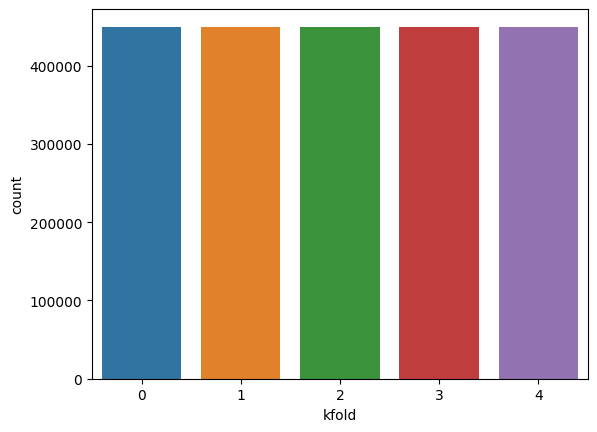

In [ ]:
sns.countplot(x='kfold' , data=temp)

In [ ]:
train_temp = temp

In [ ]:
import pandas as pd
k_folds = 5
values_per_fold = 40000

selected_df = pd.DataFrame()

for fold in range(k_folds):
    fold_values = train_temp[train_temp['kfold'] == fold].sample(n=values_per_fold, random_state=42)
    selected_df = selected_df.append(fold_values)

selected_df.reset_index(drop=True, inplace=True)
selected_df.head(20)

<ipython-input-37-128f07f9aa41>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-128f07f9aa41>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-128f07f9aa41>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-128f07f9aa41>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_df = selected_df.append(fold_values)
<ipython-input-37-128f07f9aa41>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,kfold,text
0,1505480,"Select settings [100 COUNT] Microwaveable, com...","[INCLUDES: 100 light brown compostable bowls.,...",Your dinnerware matters. It helps to define an...,474,2108,0,"Select settings [100 COUNT] Microwaveable, com..."
1,2447219,The Customer Service In Africa: How To Improve...,,,6142,12,0,The Customer Service In Africa: How To Improve...
2,369455,Brentwood (Images of America),,,223,229,0,Brentwood (Images of America)
3,404896,Claire's Sketch Pad: 50 Blank Pages to draw an...,,,10,81,0,Claire's Sketch Pad: 50 Blank Pages to draw an...
4,463483,2011/12 Boston Restaurants (Zagat Survey Bosto...,,,12316,68,0,2011/12 Boston Restaurants (Zagat Survey Bosto...
5,2320580,ArtzFolio Autumn Leaf Bulletin Board Notice Pi...,[MULTI-PURPOSE USE: Flexible mounting | Use it...,<p><strong>Pin Board; Dark Brown Frame || SIZE...,5267,441,0,ArtzFolio Autumn Leaf Bulletin Board Notice Pi...
6,2477977,PradhCases Name II Initial II Letter II Alphab...,"[PradhCases is ""Made in India' product using s...",This Case is Made up of Hard Polycarbonate Pla...,12064,36,0,PradhCases Name II Initial II Letter II Alphab...
7,2603237,"Jbehor Winter Boots for Women,Women's Short Sn...",,,2277,9,0,"Jbehor Winter Boots for Women,Women's Short Sn..."
8,2395668,CiniQy Life Size Scary Talking Witch Halloween...,[HALLOWEEN PROP:This scary Witch hanging decor...,<p>Supreme quality</p><p>Creepy appearance in ...,1608,307,0,CiniQy Life Size Scary Talking Witch Halloween...
9,2026892,Swiss Tech Performance Gear Men's Long-Sleeve ...,"[Midweight, Hooded,Zip front closure, Long-Sle...",Embrace the seasonal change with an outerwear ...,2833,142,0,Swiss Tech Performance Gear Men's Long-Sleeve ...


<Axes: xlabel='kfold', ylabel='count'>

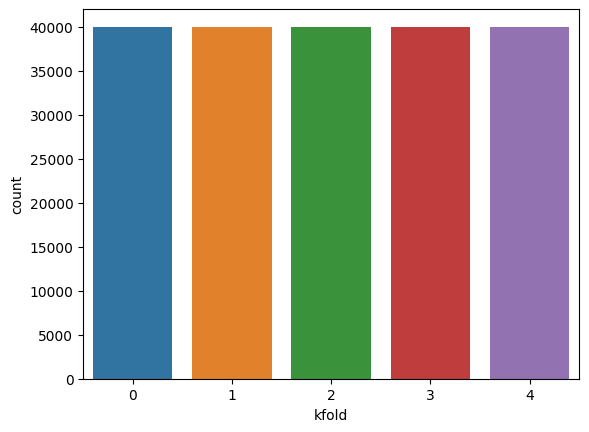

In [ ]:
sns.countplot(x='kfold' , data=selected_df)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
import nltk
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stopwords])
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    tokens = [word for word, tag in tagged if tag != 'NNP' and tag != 'NNPS']
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text
selected_df['text'] = selected_df['text'].apply(clean_text)

In [ ]:
selected_df.to_csv('amazon_cleaned.csv', index=False)

In [ ]:
dev=torch.device('cuda')

In [ ]:
temp["PRODUCT_LENGTH"].value_counts()

12       53033
9        32163
17       25002
8        23281
81       17934
         ...  
5268         1
9143         1
5346         1
8702         1
10460        1
Name: PRODUCT_LENGTH, Length: 10859, dtype: int64

In [ ]:
temp.to_csv('kfold5.csv', index=False)

In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(temp['text'], temp['PRODUCT_LENGTH'],
                                                                    test_size=0.05)

In [ ]:
train_text=train_text.reset_index(drop=True)
train_labels=train_labels.reset_index(drop=True)
val_text=val_text.reset_index(drop=True)
val_labels=val_labels.reset_index(drop=True)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

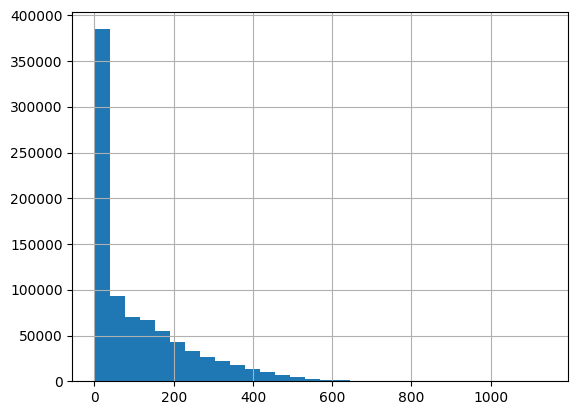

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 64

In [ ]:
class amazonDataset(Dataset):
  def __init__(self,text,label,tokenizer):
    self.sentence=text
    self.label=label
    self.tokenizer=tokenizer

  def __len__(self):
    return len(self.sentence)
  
  def __getitem__(self,idx):
    inp_tokens=self.tokenizer.encode_plus(self.sentence[idx], 
                                          padding="max_length", 
                                          add_special_tokens=True,
                                          max_length=max_seq_len, 
                                          truncation=True)
    inp_id=inp_tokens.input_ids
    inp_mask=inp_tokens.attention_mask
    inp_type_ids=inp_tokens.token_type_ids
    labels=self.label[idx]

    return {
#         "text":self.sentence,
        "input_ids":torch.tensor(inp_id, dtype=torch.long),
        "input_attention_mask":torch.tensor(inp_mask, dtype=torch.long),
        "input_type_ids":torch.tensor(inp_type_ids, dtype=torch.long),
        "labels":torch.tensor(labels, dtype=torch.float)
    }

In [ ]:
train_dataset = amazonDataset(train_text, train_labels, tokenizer)
val_dataset = amazonDataset(val_text, val_labels, tokenizer)

In [ ]:
train_dataloader=DataLoader(train_dataset,
                            batch_size=128,
                            shuffle=True,
                            num_workers=2,
                           pin_memory=True)
val_dataloader=DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=2,
                           pin_memory=True)

In [ ]:
dataloaders={'train':train_dataloader, 'eval':val_dataloader }
dataset_sizes={'train':len(train_dataset), 'eval':len(val_dataset)}

In [ ]:
model=BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                    num_labels=9919)
print(model)
model=torch.load("../input/amazon-ml-models/BERTBaseBaselineNoset.pth")
model.to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)